# TP1
## Question 1.1
Installer les packages


In [24]:
%pip install numpy pandas matplotlib scikit-learn mlxtend


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Importer les librairies et lecture des fichiers .csv et .json

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import json 
from sklearn.preprocessing import LabelEncoder
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np

user = pd.read_csv('users_data.csv')
card = pd.read_csv('cards_data.csv')
transaction  = pd.read_csv('transactions_data.csv', dtype={'zip': str})

with open('mcc_codes.json', 'r') as f:
        mcc_code = json.load(f)
        

Faire des merges pour avoir une seule dataframe

In [26]:
# Fusion des tableaux user et card selon le id user
user_card = pd.merge(user, card, how = 'left', left_on = 'id', right_on='client_id',suffixes=('_user','_card')).drop('client_id',axis = 1)

# Fusion des tableau card et transaction selon le id card
df = pd.merge(user_card, transaction, how = 'left', left_on = 'id_card', right_on='card_id',suffixes=('_user','_transaction')).drop(columns=['card_id','client_id'])
df.rename(columns={'id': 'id_transaction'}, inplace=True)

MemoryError: Unable to allocate 1.19 GiB for an array with shape (12, 13307990) and data type int64

In [ ]:
df.head()

,id_user,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,...,id_transaction,date,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,...,7482110.0,2010-01-02 16:41:00,$26.32,Swipe Transaction,54850.0,Mira Loma,CA,91752.0,4814.0,NaN
1,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,...,7483459.0,2010-01-03 06:54:00,$57.82,Swipe Transaction,50072.0,La Verne,CA,91750.0,5912.0,NaN
2,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,...,7484860.0,2010-01-03 11:58:00,$29.46,Swipe Transaction,69374.0,La Verne,CA,91750.0,5300.0,NaN
3,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,...,7487259.0,2010-01-04 06:08:00,$157.04,Swipe Transaction,61195.0,Mira Loma,CA,91752.0,5541.0,NaN
4,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,...,7490108.0,2010-01-04 16:43:00,$13.28,Swipe Transaction,81833.0,La Verne,CA,91750.0,5912.0,NaN


##  Question 1.2

Dans le tableau user, les variables les moins pertinants sont current_age, retirement_age, latitude, longitude. On n'a pas besoin de savoir l'âge du user si on peut le calculer à partir de la date de naissance. La latitude et la longitude ne sont pas nécessaire lorsqu'on possède l'adresse.

In [ ]:
drop_col =["current_age","retirement_age","latitude", "longitude"]
df.drop(columns = drop_col,inplace=True)

## Question 1.3
les variables les moins pertinants sont current_age, retirement_age, latitude, longitude. On n'a pas besoin de savoir l'âge du user si on peut le calculer à partir de la date de naissance. La latitude et la longitude ne sont pas nécessaire lorsqu'on possède l'adresse
Enlever duplicate

In [ ]:
df = df.drop_duplicates(subset=['id_user', 'id_card', 'id_transaction'])

MemoryError: Unable to allocate 1.88 GiB for an array with shape (19, 13307990) and data type object

Traitement données manquantes

In [ ]:
df.isna().sum()

In [ ]:
df.isna().mean()*100

In [ ]:
df.dropna(subset='id_transaction', inplace=True)
df.fillna({'errors' : 'no error', }, inplace=True)

df.loc[df['merchant_city'] == 'ONLINE', 'merchant_state'] = 'ONLINE'
df.loc[df['merchant_city'] == 'ONLINE', 'zip'] = 'ONLINE'
df.loc[(df['merchant_state'] != "ONLINE") & (df['merchant_state'].str.len() > 2), 'zip'] = "outside US"

In [ ]:
df.isna().sum()

Ajuster type de données

In [ ]:

# Ajuster type de données de string à float
for col in ["per_capita_income", "yearly_income", "total_debt", "credit_limit","amount"]:
    df[col] = df[col].replace(r"[\$,]", "", regex=True).astype(float)

# Ajuster type de données de string à datetime
for col,formt in [("acct_open_date",'%m/%Y'),("expires",'%m/%Y'),("date",'%Y-%m-%d %H:%M:%S'),("year_pin_last_changed","%Y")]:
    df[col] = pd.to_datetime(df["acct_open_date"],errors='coerce',format =formt)

# Ajuster type de données de string à bool
for col in ["has_chip","card_on_dark_web"]:
    df[col] = df[col].str.lower().map({"yes": True, "no": False})

## Question 1.4
Pour birth_year, birth_month, il  est inutile d'avoir 2 colonnes pour la date de naissance. Dans le tableau transaction les variables merchant_city, merchant_state pourrait juste être une adresse.

## Question 1.5

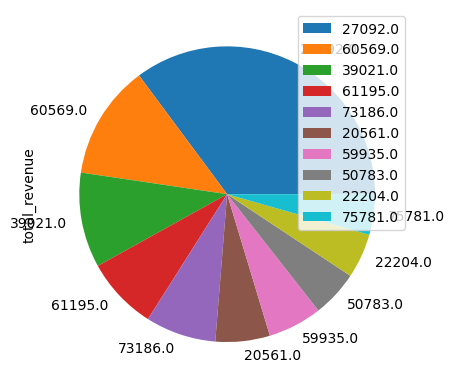

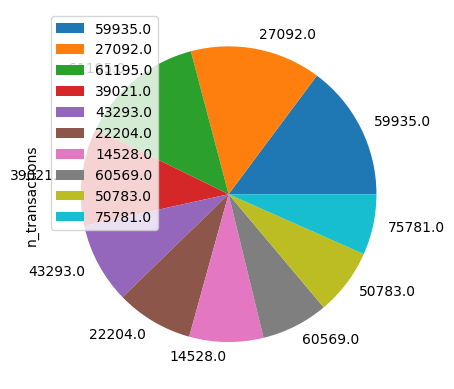

In [ ]:
merchant = df.groupby("merchant_id").agg({
    "id_transaction": "count",
    "amount": "sum"
}).rename(columns={
    "id_transaction": "n_transactions",
    "amount": "total_revenue"
})

top_merchant_revenue = merchant.nlargest(10, "total_revenue")
top_merchant_count   = merchant.nlargest(10, "n_transactions")

top_merchant_revenue.plot(kind = 'pie',y = 'total_revenue')
top_merchant_count.plot(kind = 'pie',y = 'n_transactions')
plt.show()



## Question 1.6

In [ ]:
df['mcc_category'] = df['mcc'].map(mcc_code)

encoder = LabelEncoder()
df['card_type_encode'] = encoder.fit_transform(df["card_type"])

## Question 2

In [27]:
q1 = df['amount'].quantile(0.25)
q2 = df['amount'].quantile(0.50)
q3 = df['amount'].quantile(0.75)

def categorize_amount_quartile ( x ) :
    if x <= q1 :
        return 'amount_low '
    elif x <= q2 :
        return  'amount_medium'
    elif x <= q3 :
        return 'amount_high '
    else :
        return 'amount_very_high'
    
df['amount_item '] = df['amount'].apply(categorize_amount_quartile)
df['credit_score_item '] = df['credit_score'].apply( 
    lambda x : 'credit_high' if x >= 700 else ('credit_medium' if
    x >= 500 else 'credit_low')
)
df['card_type_item'] = df['card_type'].apply( lambda x : f'card_ {x.lower ()}')
df['merchant_state_item'] = df['merchant_state'].apply( lambda x :f'state_ {x}')
df['mcc_item'] = df['mcc_description'].apply( lambda x : f'mcc_ {x.replace (" " , "_"). lower ()}')

cols_to_unstack = ['mcc_item ', 'card_type_item ','merchant_state_item ', 'amount_item', 'credit_score_item']
df_base = df[[ 'client_id_x ', 'card_id ']]. copy ()
df_base.rename( columns ={ 'client_id_x ': 'client_id '} , inplace = True)
df_long = pd.melt(pd.concat([ df_base ,df[ cols_to_unstack ]] , axis =1) ,id_vars =[ 'client_id ', 'card_id '] , value_vars = cols_to_unstack , value_name ='itemname ') [[ 'client_id ', 'card_id ', 'itemname ']]


TypeError: unsupported operand type(s) for -: 'str' and 'str'